Estimate impulse responses to word onset and surprisal in the Brennan 2018 dataset, controlling (hopefully eventually) for word acoustics.

In [44]:
import logging
logging.basicConfig(level=logging.DEBUG, handlers=[])
import os
from pathlib import Path
import re
from typing import List

from matplotlib import pyplot as plt

import mne
os.environ["MNE_TQDM"] = "off"
mne.set_log_level(logging.WARNING)

from mne.decoding import ReceptiveField
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.signal
import scipy.stats
from tqdm.notebook import tqdm

basedir = Path("..").resolve()
import sys
sys.path.append(str(basedir))

DATA_DIR = Path("/om/data/public/language-eeg/brennan2018-v2")
STIM_PATH = Path("../output/brennan2018/stim_df_with_surprisals.csv")

FILTER_WINDOW = (0.5, 20)
RF_WINDOW = (0.0, 0.90625)

SAMPLE_RATE_FOR_REGRESSION = 128

# TODO: What is right for this montage?
# N400_ELECTRODES = ["1", "14", "24", "25", "26", "29", "30", "31", "41", "42", "44", "45"]
# Picking some central sensors here, following Gillis
# N400_ELECTRODES = ["45", "34", "35", "1"]
N400_ELECTRODES = ["1", "4", "5", "6"]

In [2]:
%load_ext autoreload
%autoreload 2

In [56]:
from mfn400.adapters.brennan2018 import BrennanDatasetAdapter
from mfn400.trf import TRFEstimator

In [57]:
data = BrennanDatasetAdapter(DATA_DIR, stim_path=STIM_PATH)

loading subject data:   0%|          | 0/33 [00:00<?, ?it/s]

2022-08-18 13:57:59 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 1
2022-08-18 13:57:59 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 1
2022-08-18 13:58:01 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 3
2022-08-18 13:58:01 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 3
2022-08-18 13:58:03 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 4
2022-08-18 13:58:03 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 4
2022-08-18 13:58:05 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 5
2022-08-18 13:58:05 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 5
2022-08-18 13:58:07 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 6
2022-08-18 13:58:07 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 6
2022-08-18 13:58:09 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 8
2022-08-18 13:58:09 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 8
2022-08-18 13:58:11 | DEBUG 

In [58]:
data.run_preprocessing(filter_window=FILTER_WINDOW)

preprocessing subjects:   0%|          | 0/33 [00:00<?, ?it/s]

2022-08-18 13:59:01 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 1
2022-08-18 13:59:01 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 1
2022-08-18 13:59:02 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 3
2022-08-18 13:59:02 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 3
2022-08-18 13:59:03 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 4
2022-08-18 13:59:03 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 4
2022-08-18 13:59:03 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 5
2022-08-18 13:59:03 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 5
2022-08-18 13:59:04 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 6
2022-08-18 13:59:04 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 6
2022-08-18 13:59:05 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 8
2022-08-18 13:59:05 | DEBUG    | mfn400.ada

/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/broderick2018/mfn400/adapters/brennan2018.py:133: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw = raw.filter(*filter_window)


2022-08-18 13:59:11 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 17
2022-08-18 13:59:11 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 17
2022-08-18 13:59:12 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 18
2022-08-18 13:59:12 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 18
2022-08-18 13:59:13 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 19
2022-08-18 13:59:13 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 19
2022-08-18 13:59:14 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 20
2022-08-18 13:59:14 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 20
2022-08-18 13:59:15 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 21
2022-08-18 13:59:15 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 21
2022-08-18 13:59:16 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 22
2022-08-18 13:59:16 | DEBUG    |

In [59]:
# HACK: merge in control features computed from Alice repo.
# if this ends up working, we definitely need to merge in that code and clean this up.
predictors = np.load(DATA_DIR / "predictors.npz")
list(predictors.keys())

['1/gammatone-8',
 '2/gammatone-8',
 '3/gammatone-8',
 '4/gammatone-8',
 '5/gammatone-8',
 '6/gammatone-8',
 '7/gammatone-8',
 '8/gammatone-8',
 '9/gammatone-8',
 '10/gammatone-8',
 '11/gammatone-8',
 '12/gammatone-8']

In [60]:
def process_key(key_str):
    match = re.findall(r"^(\d+)/(.+)$", key_str)[0]
    return (int(match[0]), match[1])

In [61]:
def sanity_check_onsets(segment_onsets):
    # Sanity check: each segment's predictors should fit within the presentation time
    for key, value in predictors.items():
        segment, feature = process_key(key)
        duration = value[-1, 0] - value[0, 0]

        if segment in segment_onsets.index and segment + 1 in segment_onsets.index:
            assert duration < segment_onsets.loc[segment + 1] - segment_onsets.loc[segment]

def prepare_trf_inputs(subject_idx):
    presentation_df = data.get_presentation_data(subject_idx).copy()
    
    segment_onsets = presentation_df.groupby("segment_idx").segment_onset.min()
    sanity_check_onsets(segment_onsets)
    
    sample_times = predictors["1/gammatone-8"][:, 0]
    assert SAMPLE_RATE_FOR_REGRESSION == 1 / (sample_times[1] - sample_times[0]), \
        "Control features are not sampled at target rate for regression"
    
    raw = data._raw_data[subject_idx].pick_types(eeg=True).resample(SAMPLE_RATE_FOR_REGRESSION)
    Y = raw.get_data("eeg").T
    
    gammatone_features = [f"gammatone-{i+1}" for i in range(8)]
    presentation_features = ["word_onset", "word_surprisal", "word_logfreq", "sound_power"]
    n_features = len(gammatone_features) + len(presentation_features)

    X = np.zeros((Y.shape[0], n_features))
    presentation_df["sample_idx"] = np.floor(presentation_df.onset * raw.info["sfreq"]).astype(int)
    for segment_idx, segment_onset in segment_onsets.iteritems():
        segment_onset_sample = int(np.floor(segment_onset * raw.info["sfreq"]))

        # Add Gammatone data.
        gammatone_data = predictors[f"{segment_idx}/gammatone-8"][:, 1:]
        assert gammatone_data.shape[1] == 8
        X[segment_onset_sample:segment_onset_sample + gammatone_data.shape[0], :8] = gammatone_data

        # Word onset
        X[presentation_df.sample_idx, 8] = 1
        # X[presentation_df.sample_idx, 9] = presentation_df.IsLexical
        X[presentation_df.sample_idx, 9] = presentation_df.surprisal
        X[presentation_df.sample_idx, 10] = presentation_df.word_freq_surp
        X[presentation_df.sample_idx, 11] = presentation_df.SndPower
        
    X[np.isnan(X)] = 0.
    feature_names = gammatone_features + presentation_features
        
    return feature_names, X, Y

In [62]:
subjects = data._raw_data.keys()
# Fit all channels.
fit_channels = None
residualize_features = ["word_onset", "word_logfreq", "word_surprisal"]

In [63]:
trf_inputs = [prepare_trf_inputs(subject_idx) for subject_idx in tqdm(subjects)]
mne_info = next(iter(data._raw_data.values())).info

  0%|          | 0/33 [00:00<?, ?it/s]

In [82]:
hparam_grid = {"regressor__trf__estimator": np.logspace(1, 10, num=20)}
estimators = [TRFEstimator(subject_i, feature_names, mne_info,
                               hparam_grid=hparam_grid,
                               fit_channels=N400_ELECTRODES,
                               residualize_features=residualize_features,
                               tmin=RF_WINDOW[0], tmax=RF_WINDOW[1])
              for subject_i, (feature_names, _, _) in zip(subjects, trf_inputs)]

In [83]:
for estimator, (_, X, Y) in tqdm(zip(estimators, trf_inputs), unit="subject", total=len(estimators)):
    estimator.fit(X, Y)

  0%|          | 0/33 [00:00<?, ?subject/s]

Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 epochs, 12 channels
Fitting 1 

In [84]:
df = pd.concat([estimator.to_pandas() for estimator in estimators])
scores = np.stack([estimator.scores_ for estimator in estimators])
best_hparams = np.stack([estimator.best_hparams_ for estimator in estimators])

In [85]:
df.to_csv("fit_mne_trf.csv")

In [86]:
np.savez("fit_mne_trf_results.npz", scores=scores, best_hparams=best_hparams)

In [87]:
most_negative_sensors = df[(df.epoch_time > 0.3) & (df.epoch_time < 0.5)] \
    .groupby(["feature", "sensor"]).coef.mean() \
    .groupby("feature").nsmallest(5)
most_negative_sensors

feature         feature         sensor
gammatone-1     gammatone-1     6        -6.377481e-05
                                1        -4.849549e-05
                                5        -2.524942e-05
                                4         2.201266e-05
gammatone-2     gammatone-2     4        -1.024009e-04
                                1        -7.225466e-05
                                5        -5.273385e-05
                                6        -2.292498e-05
gammatone-3     gammatone-3     5        -3.068569e-04
                                6        -3.019882e-04
                                4        -2.721955e-04
                                1        -2.455354e-04
gammatone-4     gammatone-4     1        -2.749823e-04
                                4        -2.431576e-04
                                5        -2.372473e-04
                                6        -2.084885e-04
gammatone-5     gammatone-5     6        -1.326354e-04
                          

In [88]:
target_feature = "word_surprisal"
most_negative_sensors.loc[target_feature]

feature         sensor
word_surprisal  4        -0.000182
                5        -0.000181
                1        -0.000177
                6        -0.000166
Name: coef, dtype: float64

In [89]:
montage = mne.channels.make_standard_montage("easycap-M10")

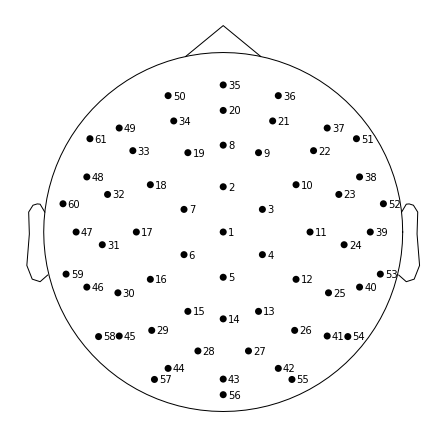

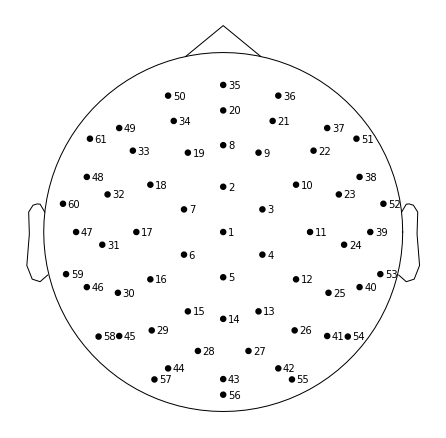

In [90]:
mne.viz.plot_montage(montage)

In [91]:
def plot_coefs(df, sensors: List[str], facet=True, ci=95, **kwargs):
    to_plot = df[df.sensor.isin(sensors) & ~df.feature.str.startswith("binned")].sort_values("sensor")
    
    if facet:
        if facet == True:
            facet = "sensor"
        g = sns.FacetGrid(data=to_plot.reset_index(), col=facet, col_wrap=4,
                          sharex=True, sharey=True, height=7)
        g.map(sns.lineplot, "epoch_time", "coef", "feature",
              ci=ci, **kwargs)
        g.add_legend()
        
        axes = g.axes.flat
        ret = g
    else:
        ax = sns.lineplot(data=to_plot.reset_index(),
                          x="epoch_time", y="coef", hue="feature",
                          ci=ci, **kwargs)
        axes = [ax]
        ret = ax

    for ax in axes:
        ax.set_xlabel("Epoch time")
        ax.set_ylabel("TRF coefficient")
        
        ax.axhline(0, c="gray", alpha=0.3)
        ax.axvline(0, c="gray", alpha=0.3)
        ax.axvline(0.3, c="gray", alpha=0.3, linestyle="dashed")
        ax.axvline(0.5, c="gray", alpha=0.3, linestyle="dashed")
        
    plt.subplots_adjust(top=0.9)
    plt.suptitle(f"TRF weights, avg over {len(to_plot.subject.unique())} subjects $\\times$ {len(to_plot.split.unique())} CV folds")
    plt.tight_layout()
        
    return ret

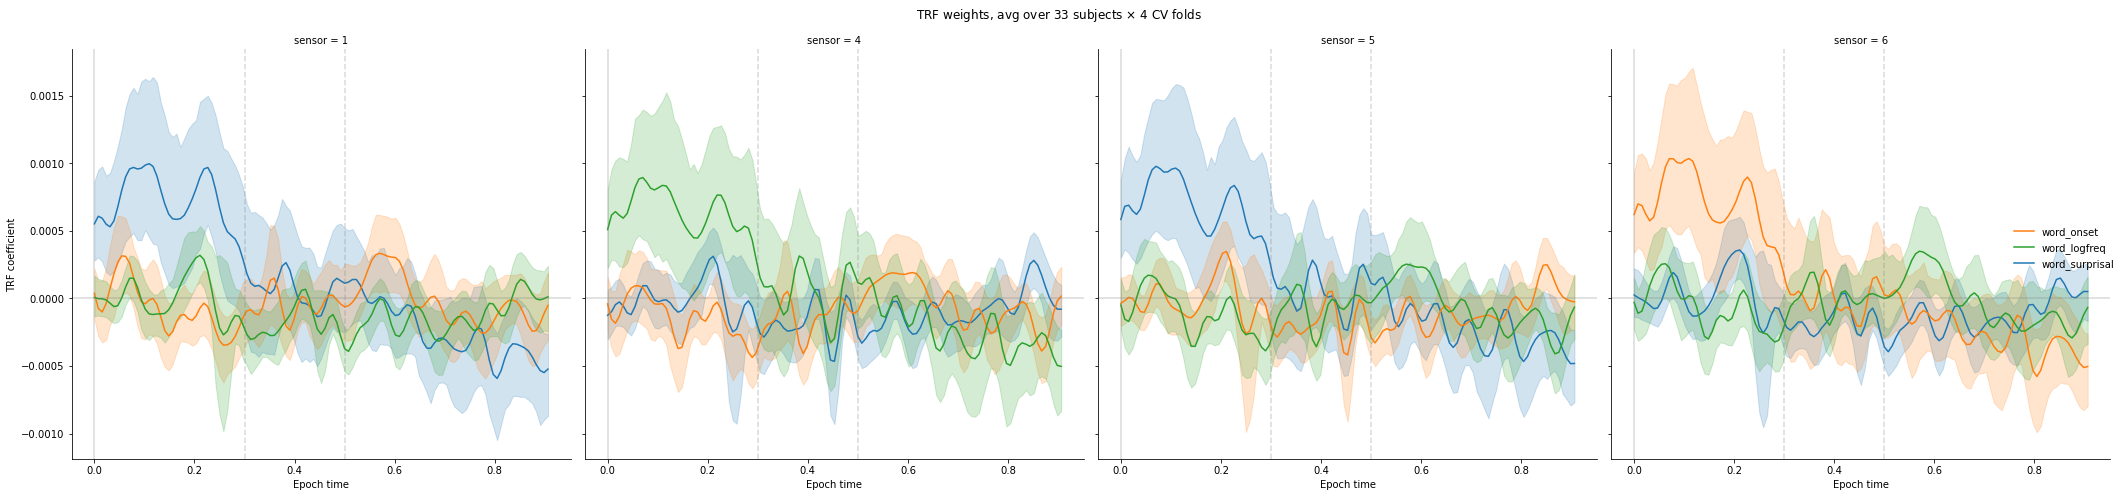

In [92]:
plot_sensors = most_negative_sensors.loc[target_feature].index.get_level_values("sensor")
plot_features = ["word_onset", "word_logfreq", "word_surprisal"]
g = plot_coefs(df[df.feature.isin(plot_features)], sensors=plot_sensors, facet=True)
# g.savefig("fit_mne_trf_bestsurp.png")

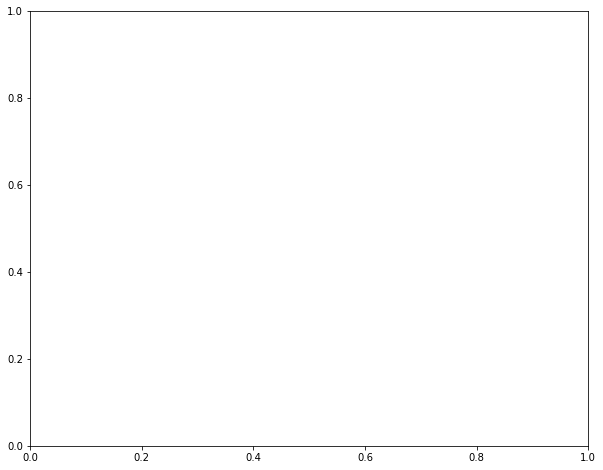

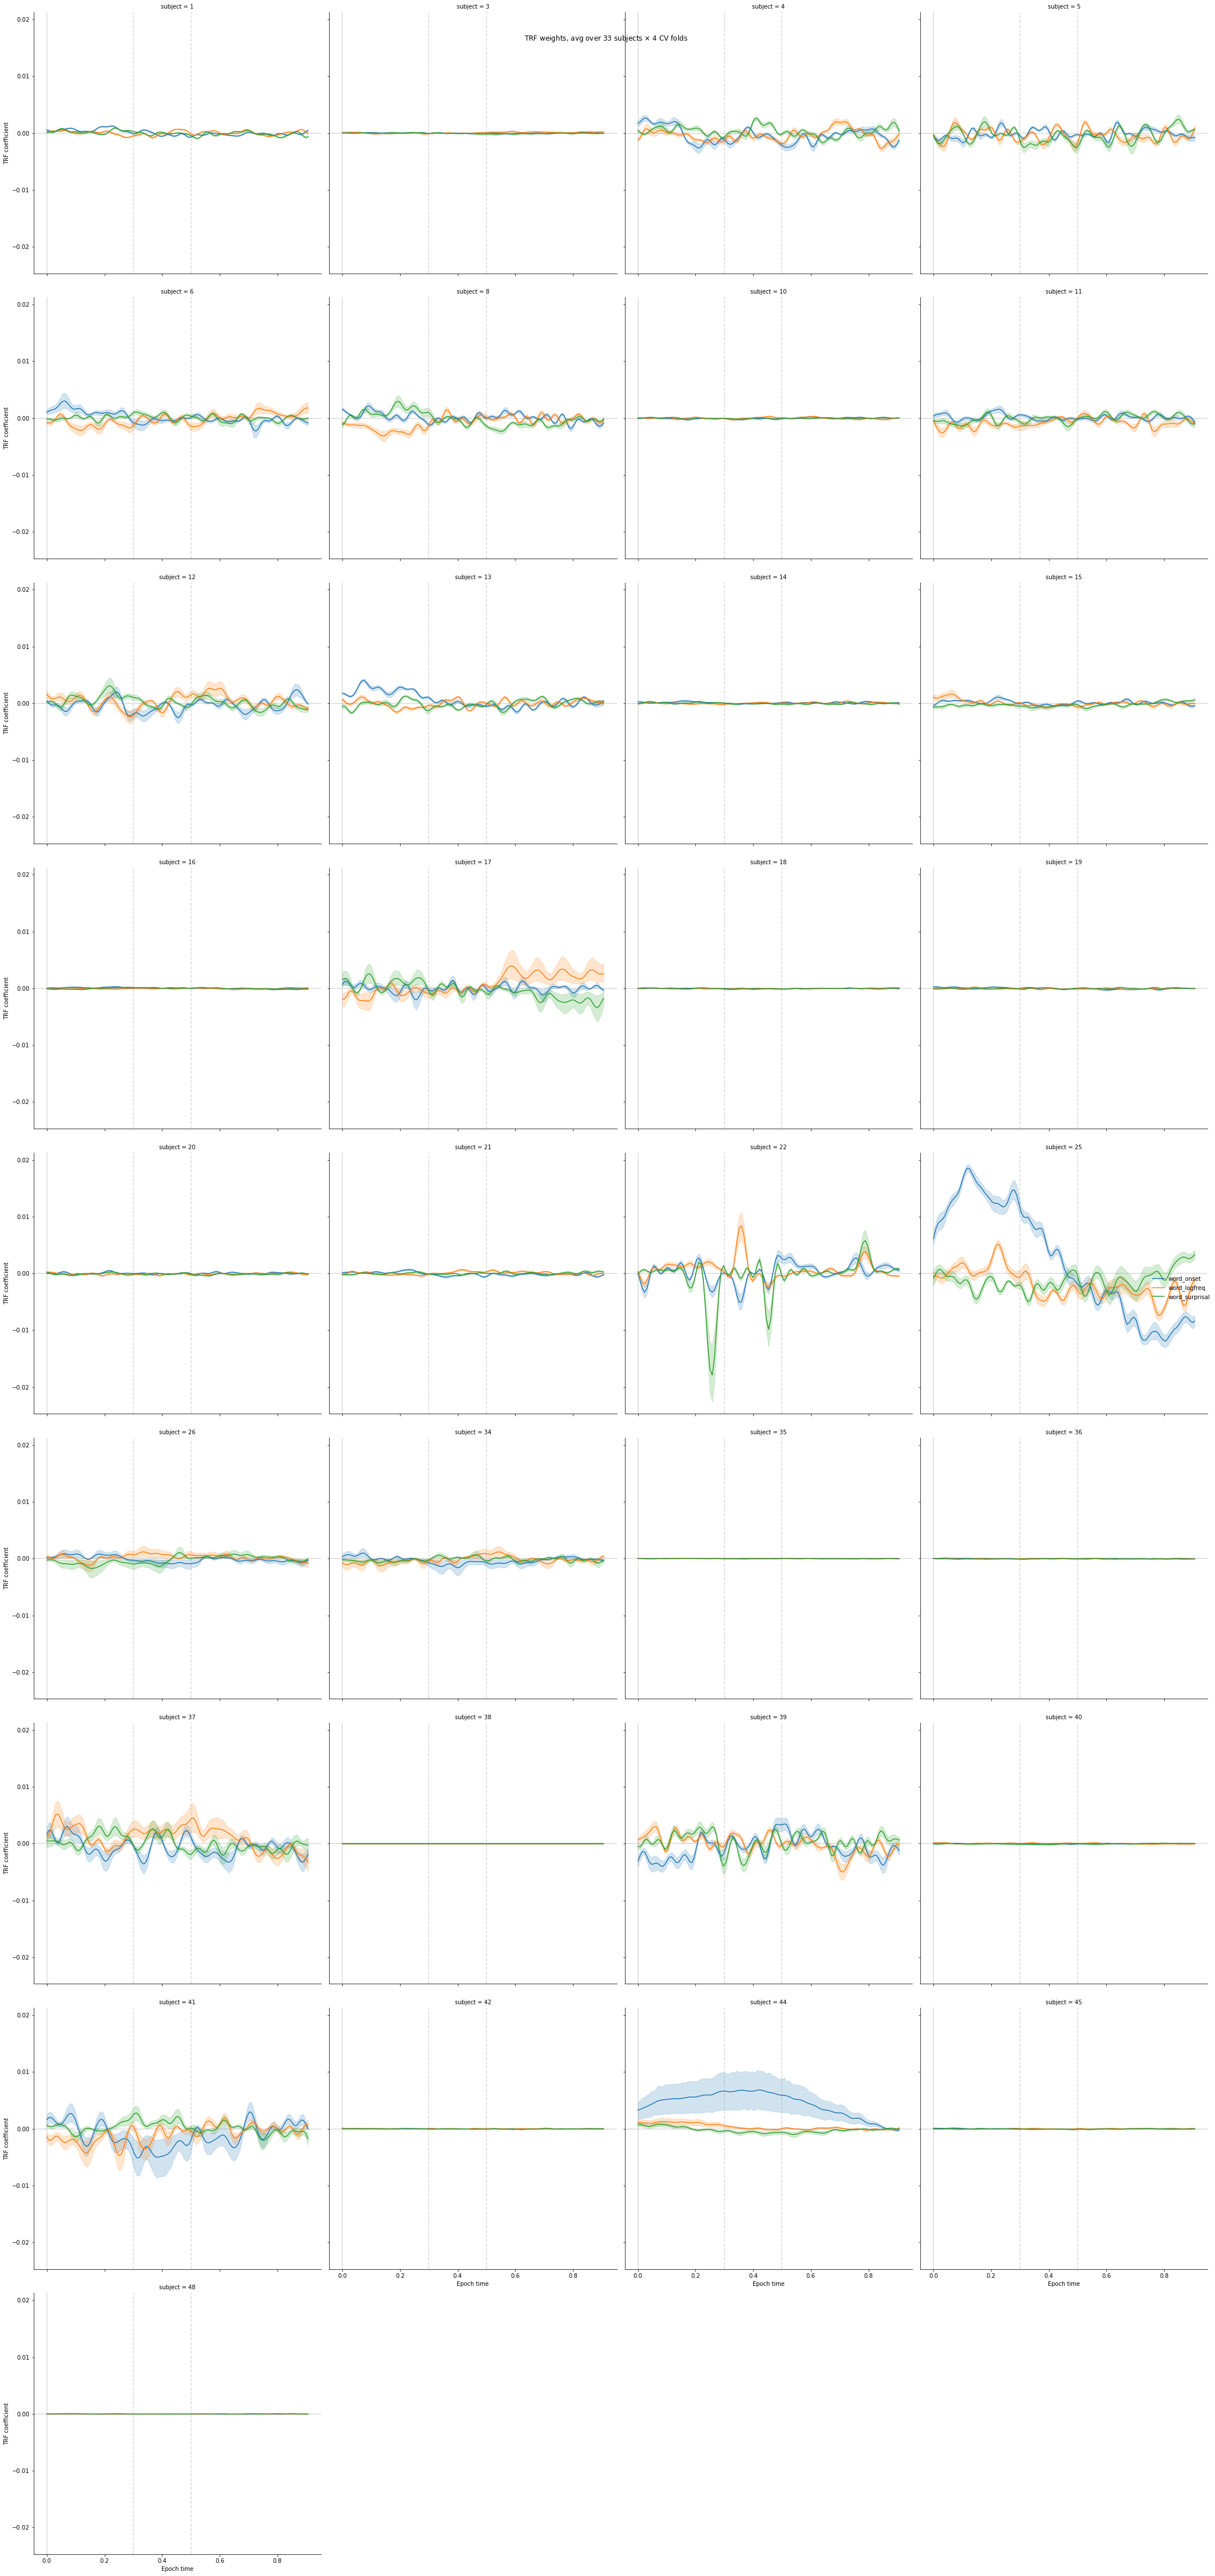

In [93]:
# Use sensors tested in paper; average together
plot_sensors = ["1", "4", "5", "6"]
plot_features = ["word_onset", "word_logfreq", "word_surprisal"]
plt.subplots(figsize=(10, 8))
plot_coefs(df[df.feature.isin(plot_features)],
           sensors=plot_sensors, facet="subject", hue_order=plot_features)